## EJECUTAR

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, Graph 
from models.database import *
from models.models import *
import os
from sqlalchemy.orm import Session
import json
from grafo.tools import *
from datetime import datetime
import time
#from dotenv import load_dotenv

In [5]:
import logging

# Opción suave: solo mostrar warnings y errores
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)
logging.getLogger('sqlalchemy.pool').setLevel(logging.WARNING)

# Opción más fuerte: silenciar todo lo de SQLAlchemy
logging.getLogger('sqlalchemy').setLevel(logging.CRITICAL)


In [3]:
#load_dotenv()
MODELO = os.getenv("MODELO")
KEY = os.getenv("KEY")
VERSION = os.getenv("VERSION")
ENDPOINT = os.getenv("ENDPOINT")

MAIL_ENVIO = os.getenv("MAIL_ENVIO")

In [4]:
llm = AzureChatOpenAI(
    api_key = KEY,
    api_version = VERSION,
    azure_endpoint = ENDPOINT,
    azure_deployment = MODELO
    )

## AQUI YA NO

In [ ]:
import openai
openai_client = openai.AzureOpenAI(
    api_key = KEY,
    api_version = VERSION,
    azure_endpoint = ENDPOINT
    )

In [ ]:
messages=[{"role": "system", "content": "Eres un asistente útil."},
        {"role": "user", "content": "¿Cuál es la capital de España?"}]

response = openai_client.chat.completions.create(
    model = MODELO,
    messages = messages,
    max_tokens=100
    )
response.choices[0].message.content

In [ ]:
# Agrego un proveedor de prueba

def agregar_proveedor_prueba():
    """
    Agrega un proveedor de prueba a la base de datos.
    """
    session = Session(bind=engine)

    # Crear un proveedor de prueba
    nuevo_proveedor = Proveedor(
        nombre="Apple",
        contacto="Soporte Apple",
        email="apple@proveedor.com",
        estado="aprobado"
    )
    session.add(nuevo_proveedor)
    session.commit()

    print(f"✅ Proveedor de prueba añadido: {nuevo_proveedor.nombre} (ID: {nuevo_proveedor.id_proveedor})")
    session.close()

# Ejecutar la función para agregar el proveedor
agregar_proveedor_prueba()


PENDIENTE QUE SE GENERE UNA DESCRIPCION AUTOMATICA POR LA IA Y LE PONGA NOMBRE A LA CESTA EL AGENTE OBTENER DATOS PEDIDO.

## NODO 1 - DATOS PEDIDO 
Este nodo se encarga de obtener los datos del pedido asigna el estado de pedido condicionado o no condicionado en funcion de si encuentra o no datos en la tabla pedidos.

In [21]:
def obtener_datos_pedido(entrada_usuario):
    ''' Nodo que usa IA para obtener los datos del pedido del usuario, crea la cesta y el pedido con el estado inicial,
      y decide si el flujo valida el proveedor o graba la cesta.
    '''
    # Se crea la sesión de SQLAlchemy	
    session = Session(bind=engine)

    prompt = f''' 
    Eres el encargado de obtener la información de un pedido.
    Se necesita conocer:
    - Nombre del proveedor (si no se menciona, deja "desconocido")
    - Moneda en la que se realizó la compra utiliza el codigo de 3 letras
    - Presupuesto estimado
    - Producto a comprar

    {entrada_usuario}

    Devuelve los datos en un formato claro como:
    "Proveedor: Proveedor X, Moneda: EUR, Presupuesto: 5000, Producto: [Producto Y], Cantidad: 10"
    '''
    response = llm.invoke(prompt)
    datos_ia = response.content.strip()

    print(f'IA: {datos_ia}')

    # Extraer los datos del texto
    datos_extraidos = {}
    for item in datos_ia.split(','):
        key, value = item.strip().split(':')
        datos_extraidos[key.lower().strip()] = value.strip()
    
    nombre_proveedor = datos_extraidos.get('proveedor', 'desconocido').strip().lower()
    codigo_moneda = datos_extraidos.get('moneda', 'EUR').strip().upper() 
    presupuesto = float(datos_extraidos.get('presupuesto', 1000)) # Por defecto 1000
    producto = datos_extraidos.get('producto', 'no especificado')
    cantidad = int(datos_extraidos.get('cantidad', 1)) # Por defecto 1
    print(f"📦 Datos extraídos: Proveedor: {nombre_proveedor}, Moneda: {codigo_moneda}, Presupuesto: {presupuesto}")
    
    # Verificar si el proveedor ya existe en la BD
    proveedor = session.query(Proveedor).filter_by(nombre=nombre_proveedor).first()
    proveedor_id = proveedor.id_proveedor if proveedor else None
    # Si el proveedor existe en la BD se va por el flujo de proveedor no condicionado
    if proveedor:
        print(f"✅ Proveedor '{proveedor.nombre}' encontrado en la base de datos.")
        es_nuevo = False
        estado_inicial_nombre = "pendiente_no_condicionada"
    # Si el proveedor no existe en la BD se va por el flujo de proveedor condicionado
    else:
        print(f"⚠️ Proveedor '{nombre_proveedor}' no encontrado. Requiere validación.")
        es_nuevo = True
        estado_inicial_nombre = "pendiente_condicionada"
        entrada_usuario = input("👉 Nombre, email y contacto del proveedor (en lenguaje natural):\n").lower()
        agente_proveedor = create_react_agent(llm ,tools=[insertar_proveedores])
        # Se crea un agente que se encargara de obtener los datos del proveedor e introducirlo en la base de datos
        prompt = f''' 
        Eres el encargado de obtener la información de un proveedor.
        Se necesita conocer:
        - Nombre del proveedor 
        - Mail del proveedor
        - Contacto del proveedor

        Aqui tienes la información que tienes que obtener:

        {entrada_usuario}

        Devuelve unicamente un formato JSON como:
            "nombre": "...",
            "email": "...",
            "contacto": "..."
        '
        Una vez generado el json, utiliza la herramienta insertar_proveedores para insertar el proveedor en la base de datos y no generes ningun mensaje adicional.
        '''
        response = agente_proveedor.invoke({'messages': [HumanMessage(content = prompt)]})
        print(response['messages'][-1].content)

        # 🔁 Volver a buscar el proveedor recién insertado
        proveedor = session.query(Proveedor).filter_by(nombre=nombre_proveedor.lower()).first()
        proveedor_id = proveedor.id_proveedor if proveedor else None
        print(f"✅ Proveedor '{proveedor_id}' encontrado en la base de datos.")

    # Obtener estado inicial correspondiente
    estado_inicial = session.query(Estado).filter_by(nombre=estado_inicial_nombre).first()
    if not estado_inicial:
        print(f"⚠️ Estado '{estado_inicial_nombre}' no encontrado en la base de datos.")
        return {"error": "Estado inicial no encontrado"}

    # Verificar que la moneda existe en la BD
    moneda = session.query(Moneda).filter(Moneda.codigo == codigo_moneda).first()
    moneda_id = moneda.id_moneda if moneda else None

    if not moneda:
        print(f"⚠️ Moneda '{codigo_moneda}' no encontrada. Se usará EUR por defecto.")
        moneda = session.query(Moneda).filter_by(codigo="EUR").first()
        moneda_id = moneda.id_moneda

    # Crear la cesta y el pedido
    nueva_cesta = Cesta(
        nombre="Cesta generada automáticamente",
        descripcion="Pedido generado automáticamente",
        tipo_compra="ordinaria",
        presupuesto=presupuesto,
        usuario_sap_id=1,
        proveedor_id=proveedor_id,
        moneda_id=moneda_id,
        contrato_id=None
    )
    session.add(nueva_cesta)
    session.commit()

    print(f"✅ Cesta creada con ID: {nueva_cesta.id_cesta}")

    nuevo_pedido = Pedido(
        posicion=1,
        tipo="Ordinario",
        pedido_tipoimp="K",
        descripcion=f"Compra de {datos_extraidos.get('producto', 'productos no especificados')}",
        id_proveedor=proveedor_id,
        cesta_id=nueva_cesta.id_cesta, 
        estado_tramitacion_id=estado_inicial.id_estado,
        creador_id=1,
        moneda_id=moneda_id
    )
    session.add(nuevo_pedido)
    session.commit()

    # Se extraen las variables antes de cerrar la sesion 

    pedido_id = nuevo_pedido.id_pedido
    cesta_id = nueva_cesta.id_cesta
    session.close()

    return {

        "id_pedido": pedido_id,
        "id_proveedor": proveedor_id, # Ya no intenta acceder a un objeto desvinculado
        "nombre_proveedor": nombre_proveedor,
        "id_cesta": cesta_id,
        "id_moneda": moneda_id,  # Ya no intenta acceder a un objeto desvinculado
        "estado_actual": estado_inicial_nombre,
        "id_usuario": 1,
        "nombre_cesta": "Cesta generada automáticamente",
        "tipo_compra": "ordinaria",
        "presupuesto": presupuesto,
        "descripcion": producto,
        "pedido_tipoimp": "K",
        "cantidad": cantidad,
        "es_nuevo": es_nuevo  # Indica si el proveedor debe validarse antes de continuar
    }


## NODO 2 - DECIDE EL FLUJO EN FUNCION DE SI EL PEDIDO ESTA CONDICIONADO O NO


In [ ]:
def decidir_siguiente_nodo(datos):
    """
    Determina si el flujo sigue a `grabar_cesta_srm` o `gestionar_proveedor_nuevo`
    dependiendo de si el proveedor es nuevo o no.
    """

    if isinstance(datos, tuple):
        datos = datos[1]  # 🔹 Solo nos interesa la segunda parte de la tupla

    # 📌 Validar si el proveedor es nuevo
    if datos.get("es_nuevo", False):
        print("🔄 Redirigiendo a `gestionar_proveedor_nuevo`...")
        print("📤 Retornando:", ("gestionar_proveedor_nuevo", datos) if datos.get("es_nuevo") else ("grabar_cesta_srm", datos))

        return "gestionar_proveedor_nuevo", datos
    else:
        print("✅ Redirigiendo a `grabar_cesta_srm`...")
        return "grabar_cesta_srm", datos


In [23]:
datos = {
    "id_pedido": 123,
    "id_proveedor": 456,
    "nombre_proveedor": "intel",
    "id_cesta": 789,
    "id_moneda": 1,
    "estado_actual": "pendiente_no_condicionada",
    "id_usuario": 1,
    "nombre_cesta": "Cesta generada automáticamente",
    "tipo_compra": "ordinaria",
    "presupuesto": 6600,
    "descripcion": "20 portátiles",
    "pedido_tipoimp": "K",
    "es_nuevo": True  # Prueba también con False
}

# FLUJO NO CONDICIONADO

## NODO 3 - GRABAR CESTA SRM

En este caso se tienen ya los datos del proveedor, por lo que se procede a grabar la cesta en el SRM. Como no se tiene acceso a SRM, se genera un envio de datos en formato JSON, simulando esta comunicación.

PENDIENTE REVISAR LO QUE SE NECESITA EN EL SIGUIENTE NODO.

In [24]:
def grabar_cesta_srm(datos):
    """
     Simula el envío del pedido a SAP SRM, registra el estado en la BD y actualiza `HistorialPedido`
    antes de cambiar el estado a `aprobar_compra_manager`.
    """
    session = Session(bind=engine)

    if isinstance(datos, tuple):
        datos = datos[1]


    id_pedido = datos["id_pedido"]

    #  Obtener el Pedido de la base de datos
    pedido = session.query(Pedido).filter_by(id_pedido=id_pedido).first()
    
    if not pedido:
        print(f"❌ Error: No se encontró el Pedido {id_pedido}.")
        return {"error": "Pedido no encontrado"}

    #  Guardar el estado inicial del Pedido antes de enviarlo a SAP
    estado_anterior_id = pedido.estado_tramitacion_id

    #  Crear JSON para enviar a SAP SRM
    data_sap = {
        "pedido_id": pedido.id_pedido,
        "descripcion": pedido.descripcion,
        "tipo": pedido.tipo,
        "proveedor_id": pedido.id_proveedor,
        "moneda_id": pedido.moneda_id,
        "cesta_id": pedido.cesta_id
    }

    json_sap = json.dumps(data_sap, indent=4)  # 🔹 Simulación de envío
    print(f"📤 Simulando envío de Pedido {id_pedido} a SAP SRM en formato JSON:\n{json_sap}")

    response_data = {
        "status": "success",
        "message": "Pedido registrado correctamente en SAP SRM"
    }

    print(f"✅ Pedido {id_pedido} registrado en SAP SRM (simulación).")
    

    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="grabar_cesta_srm").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'grabar_cesta_srm'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior_id,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior_id} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior_id,  # 🔹 Estado antes de SAP
        estado_nuevo=nuevo_estado.id_estado,  # 🔹 Estado después de SAP
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

# FLUJO CONDICIONADO

## NODO 4 - GESTIONAR PROVEEDOR NUEVO
Este nodo es importante ya que es necesario obtener los datos del proveedor y enviar generar un pdf tipo con el informe del nuevo proveedor hacia dos departamentos para la aprobación de un nuevo proveedor en el sistema.

In [25]:
def gestionar_proveedor_nuevo(datos):
    
    session = Session(bind=engine)
    
    if isinstance(datos, tuple):
        datos = datos[1]

    nombre_proveedor = datos["nombre_proveedor"]
    email = MAIL_ENVIO
    id_pedido = datos["id_pedido"]
    filename = f"informe_proveedor_{nombre_proveedor}.pdf"

    # 👉 Tools que el agente puede usar
    tools = [generar_pdf_proveedor, enviar_correo]

    # Crear el agente con las tools
    agent_pedido = create_react_agent(llm, tools)

    # 🧠 Prompt que le dice al agente qué hacer
    prompt = f"""
    El proveedor {nombre_proveedor} es nuevo. Debes generar un informe PDF con la información del proveedor
    y enviarlo a {email} para su validación. 

    Usa la herramienta `generar_pdf_proveedor` para crear el informe en el archivo llamado "{filename}" 
    con los datos disponibles del proveedor: {datos}

    Después, usa la herramienta `enviar_correo` para enviar el informe. En el cuerpo del correo justifica 
    por qué este proveedor debe ser considerado (por ejemplo, disponibilidad, precio o características técnicas).

    No devuelvas ningún texto adicional.
    """

    print("🤖 Ejecutando agente para gestionar proveedor nuevo...")
    agent_pedido.invoke({'messages': [HumanMessage(content = prompt)]})

    # 🔄 Actualizar estado y registrar historial
    pedido = session.query(Pedido).filter_by(id_pedido=id_pedido).first()

    if not pedido:
        print(f"❌ Pedido {id_pedido} no encontrado.")
        return {"error": "pedido no encontrado"}

    estado_anterior_id = pedido.estado_tramitacion_id
    nuevo_estado = session.query(Estado).filter_by(nombre="solicitar_firma_inf_prov_cond").first()

    if not nuevo_estado:
        print("❌ Estado 'solicitar_firma_inf_prov_cond' no encontrado.")
        return {"error": "estado no encontrado"}

    # Actualizar estado
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    # Registrar en historial
    historial = HistorialPedido(
        id_pedido=id_pedido,
        estado_anterior=estado_anterior_id,
        estado_nuevo=nuevo_estado.id_estado,
        estado_aprobacion="pendiente",
        fecha_cambio=datetime.utcnow(),
        id_usuario=pedido.creador_id,
        id_transicion=1  # Si sabes el ID exacto de esta transición
    )
    session.add(historial)
    session.commit()
    session.close()

    print(f"✅ Pedido {id_pedido} actualizado a solicitar_firma_inf_prov_cond y registrado en Historial.")
    return datos


## NODO 5 - APROBACION DE INFORME PROVEEDOR CONDICIONADO
Este nodo se encarga de aprobar el informe del proveedor condicionado, en caso de que no se apruebe se vuelve a solicitar la firma del informe.

In [26]:
def aprobacion_proveedor(datos):
    # Crear la sesión de SQLAlchemy
    session = Session(bind=engine)
    # Crear el agente con las tools
    tools = [leer_bandeja_entrada]
    agent_reader = create_react_agent(llm, tools)
    # Parámetros de configuración
    max_reintentos = 5
    tiempo_espera = 60  # segundos
    # Obtener datos del pedido y proveedor
    proveedor = session.query(Proveedor).filter_by(id_proveedor=datos["id_proveedor"]).first()
    pedido = session.query(Pedido).filter_by(id_pedido=datos["id_pedido"]).first()    
    estado_anterior = pedido.estado_tramitacion_id
    # Verificar si el pedido existe
    if not pedido:
        print(f"❌ Pedido no encontrado.")
        session.close()
        return {"error": "pedido no encontrado"}

    # Realizar múltiples intentos para obtener la aprobación
    for intento in range(max_reintentos):
        print(f"⏳ Intento {intento + 1} de {max_reintentos}...")

        prompt = f""" 
        Usa la herramienta `leer_bandeja_entrada` para identificar si hay un correo de aprobación relativo al proveedor.
        utiliza los datos disponibles del proveedor para identificar al proveedor: {datos}

        Si hay un correo de aprobación -> responde: 'aprobado'
        Si hay un correo de denegación -> responde: 'denegado'
        Si no hay correo aún -> responde: 'pendiente'
        """

        print("🤖 Ejecutando agente para revisar aprobación del proveedor...")
        response = agent_reader.invoke({'messages': [HumanMessage(content=prompt)]})
        resultado = response['messages'][-1].content.lower()

        if "aprobado" in resultado:
            print("✅ Proveedor aprobado.")
            proveedor.estado = "aprobado"
            nuevo_estado = session.query(Estado).filter_by(nombre="firma_inf_prov_cond").first()
            pedido.estado_tramitacion_id = nuevo_estado.id_estado

            historial = HistorialPedido(
                id_pedido=pedido.id_pedido,
                estado_anterior=estado_anterior,
                estado_nuevo=nuevo_estado.id_estado,
                estado_aprobacion="aprobado",
                fecha_cambio=datetime.utcnow(),
                id_usuario=datos["id_usuario"],
                id_transicion=3
            )

            session.add(historial)
            session.commit()
            session.close()
            return datos

        elif "denegado" in resultado:
            print("❌ Proveedor denegado.")
            proveedor.estado = "denegado"

            session.commit()
            session.close()
            return {"aprobacion": "denegado"}

        print("⌛ No hay respuesta aún. Esperando antes del siguiente intento...")
        time.sleep(tiempo_espera)

    # Si se agota el tiempo y no hay respuesta clara
    print(f"🚫 No se ha recibido respuesta tras los {max_reintentos} intentos. Aprobación pendiente.")
    session.close()
    return {"aprobacion": "pendiente", "mensaje": "No se ha recibido aprobación tras múltiples intentos."}


## NODO 6 - LANZAR CESTA SRM PENDIENTE

In [27]:
def lanzar_cesta_srm(datos):
    """
    Simula el envío del pedido a SAP SRM despues de la aceptacion de un nuevo proveedor, 
    registra el estado en la BD y actualiza `HistorialPedido`
    antes de cambiar el estado a `aprobar_compra_manager`.
    """
    session = Session(bind=engine)

    id_pedido = datos["id_pedido"]

    #  Obtener el Pedido de la base de datos
    pedido = session.query(Pedido).filter_by(id_pedido=id_pedido).first()
    
    if not pedido:
        print(f"❌ Error: No se encontró el Pedido {id_pedido}.")
        return {"error": "Pedido no encontrado"}

    #  Guardar el estado inicial del Pedido antes de enviarlo a SAP
    estado_anterior_id = pedido.estado_tramitacion_id
    print(f"🔄 Estado anterior del Pedido {id_pedido}: {estado_anterior_id}")
    
    #  Crear JSON para enviar a SAP SRM
    data_sap = {
        "pedido_id": pedido.id_pedido,
        "descripcion": pedido.descripcion,
        "tipo": pedido.tipo,
        "proveedor_id": pedido.id_proveedor,
        "moneda_id": pedido.moneda_id,
        "cesta_id": pedido.cesta_id
    }

    json_sap = json.dumps(data_sap, indent=4)  # 🔹 Simulación de envío
    print(f"📤 Simulando envío de Pedido {id_pedido} a SAP SRM en formato JSON:\n{json_sap}")

    response_data = {
        "status": "success",
        "message": "Pedido registrado correctamente en SAP SRM"
    }

    print(f"✅ Pedido {id_pedido} registrado en SAP SRM (simulación).")
    

    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="lanzar_cesta_srm").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'lanzar_cesta_srm'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior_id,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior_id} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior_id, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

# FLUJO GENERAL

## NODO 7 - APROBAR CESTA MANAGER (pendiente validar)

In [28]:
def aprobar_compra_manager(datos):
    session = Session(bind=engine)
    # Obtener datos del pedido y proveedor
    proveedor = session.query(Proveedor).filter_by(id_proveedor=datos["id_proveedor"]).first()
    pedido = session.query(Pedido).filter_by(id_pedido=datos["id_pedido"]).first()    
    estado_anterior = pedido.estado_tramitacion_id

    tools = [enviar_correo]
    agent_sender = create_react_agent(llm, tools)
    
    prompt = f"""
    Tienes que enviar un email al responsable de aprobacion del pedido, para ello debes solicitar de forma clara la aprobacion de este pedido lo antes posible.
    
    Tienes los datos del pedido disponibles para dar un poco de contexto del proveedor y lo que se compra al que tiene que aceptar este pedido:

    {datos}

    Para el envio del mail, usa la herramienta `enviar_correo`. En el cuerpo del correo justifica 
    la compra de lo necesario.

    No devuelvas ningún texto adicional.
    """
    agent_sender.invoke({'messages': [HumanMessage(content=prompt)]})

    # Parámetros de configuración
    max_reintentos = 5
    tiempo_espera = 60  # segundos
    tools = [leer_bandeja_entrada]
    agent_reader = create_react_agent(llm, tools)
    # Realizar múltiples intentos para obtener la aprobación
    for intento in range(max_reintentos):
        print(f"⏳ Intento {intento + 1} de {max_reintentos}...")

        prompt = f""" 
        Usa la herramienta `leer_bandeja_entrada` para identificar si hay un correo de aprobación relativo al proveedor.
        utiliza los datos disponibles del proveedor para identificar al proveedor: {datos}

        Si hay un correo de aprobación -> responde: 'aprobado'
        Si hay un correo de denegación -> responde: 'denegado'
        Si no hay correo aún -> responde: 'pendiente'
        """

        print("🤖 Ejecutando agente para revisar aprobación del pedido")
        response = agent_reader.invoke({'messages': [HumanMessage(content=prompt)]})
        resultado = response['messages'][-1].content.lower()

        if "aprobado" in resultado:
            print("✅ Pedido aprobado.")
            nuevo_estado = session.query(Estado).filter_by(nombre="aprobar_compra_manager").first()
            pedido.estado_tramitacion_id = nuevo_estado.id_estado

            # Se obtiene la transicion correspondiente en la tabla transiciones
            transicion = session.query(Transicion).filter_by(
            estado_origen_id=estado_anterior,
            estado_destino_id=nuevo_estado.id_estado
            ).first()

            if not transicion:
                print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
                return {"error": "Transición no encontrada"}
            
            historial = HistorialPedido(
                id_pedido=pedido.id_pedido,
                estado_anterior=estado_anterior,
                estado_nuevo=nuevo_estado.id_estado,
                estado_aprobacion="aprobado",
                fecha_cambio=datetime.utcnow(),
                id_usuario=datos["id_usuario"],
                id_transicion=transicion.id_transicion
            )

            session.add(historial)
            session.commit()
            session.close()
            return datos

        elif "denegado" in resultado:
            print("❌ Pedido denegado.")
            proveedor.estado = "denegado"

            session.commit()
            session.close()
            return {"aprobacion": "denegado"}

        print("⌛ No hay respuesta aún. Esperando antes del siguiente intento...")
        time.sleep(tiempo_espera)

    # Si se agota el tiempo y no hay respuesta clara
    print(f"🚫 No se ha recibido respuesta tras los {max_reintentos} intentos. Aprobación pendiente.")
    session.close()
    return {"aprobacion": "pendiente", "mensaje": "No se ha recibido aprobación tras múltiples intentos."}


## NODO 8 - REVISION DE CESTA Y ENVIO DE SOLICITUD DE OFERTA A PROVEEDORES

Funciona bien, hay que volver a generar el modelo de datos por que han habido cambios y he eliminado algun estado.

In [29]:
def resumen_cesta_para_envio(datos):
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id
    
    # Recuperar relaciones
    proveedor_cesta = cesta.proveedor
    usuario_sap = cesta.usuario_sap
    moneda_cesta = cesta.moneda
    moneda_pedido = pedido.moneda
    estado_pedido = pedido.estado_tramitacion

    resumen = f"""
     RESUMEN DE CESTA

    - Tipo de compra: {cesta.tipo_compra}
    - Presupuesto: {cesta.presupuesto} {moneda_cesta.codigo if moneda_cesta else '---'}
    - Usuario SAP: {usuario_sap.nombre if usuario_sap else '---'} ({usuario_sap.email if usuario_sap else '---'})
    - Proveedor: {proveedor_cesta.nombre if proveedor_cesta else '---'} ({proveedor_cesta.email if proveedor_cesta else '---'})
    - Fecha creación: {cesta.fecha_creacion.strftime('%d/%m/%Y')}
    - Tipo imputación: {pedido.pedido_tipoimp or '---'}
    - Estado de tramitación: {estado_pedido.nombre if estado_pedido else '---'}
    - Moneda: {moneda_pedido.codigo if moneda_pedido else '---'}
    """

    tools = [enviar_correo]
    agent_sender = create_react_agent(llm, tools)

    prompt = f"""
    Tienes que enviar un email al que ha creado el pedido, para ello debes solicitar de forma clara que revise la cesta y escriba si encuentra alguna errata.
    
    Tienes los datos del pedido disponibles que se revise la cesta y se de el OK.

    {resumen}

    Para el envio del mail, usa la herramienta `enviar_correo`. En el cuerpo del correo genera un resumen de la compra.

    Si hay un correo de aprobación -> responde: 'aprobado'
    Si hay un correo donde dice que hay una error -> responde: 'errata'
    """

    agent_sender.invoke({'messages': [HumanMessage(content=prompt)]})

    # Parámetros de configuración
    max_reintentos = 5
    tiempo_espera = 60  # segundos
    tools = [leer_bandeja_entrada]
    agent_reader = create_react_agent(llm, tools)
    # Realizar múltiples intentos para obtener la aprobación
    for intento in range(max_reintentos):
        print(f"⏳ Intento {intento + 1} de {max_reintentos}...")

        prompt = f""" 
        Usa la herramienta `leer_bandeja_entrada` para identificar si hay un correo diciendo que la cesta es correcta.
        Aqui tienes los datos de la cesta por si no eres capaz de identifical el correo: {resumen}

        Si el correo acepta la cesta -> responde: 'aprobado'
        Si el correo indica que hay errores -> responde: 'errata'
        Si no hay correo aún -> responde: 'pendiente'
        """

        print("🤖 Ejecutando agente para revisar aprobación del pedido")
        response = agent_reader.invoke({'messages': [HumanMessage(content=prompt)]})
        resultado = response['messages'][-1].content.lower()

        if "aprobado" in resultado:
            print("✅ Pedido aprobado.")
            nuevo_estado = session.query(Estado).filter_by(nombre="revision_compra").first()
            pedido.estado_tramitacion_id = nuevo_estado.id_estado

            # Se obtiene la transicion correspondiente en la tabla transiciones
            transicion = session.query(Transicion).filter_by(
            estado_origen_id=estado_anterior,
            estado_destino_id=nuevo_estado.id_estado
            ).first()

            if not transicion:
                print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
                return {"error": "Transición no encontrada"}
            
            historial = HistorialPedido(
                id_pedido=pedido.id_pedido,
                estado_anterior=estado_anterior,
                estado_nuevo=nuevo_estado.id_estado,
                estado_aprobacion="aprobado",
                fecha_cambio=datetime.utcnow(),
                id_usuario=datos["id_usuario"],
                id_transicion=transicion.id_transicion
            )

            session.add(historial)
            session.commit()
            session.close()
            return datos

        elif "errata" in resultado:
            print("❌ Pedido con error.")

            session.commit()
            session.close()
            return {"aprobacion": "error"}

        print("⌛ No hay respuesta aún. Esperando antes del siguiente intento...")
        time.sleep(tiempo_espera)

    # Si se agota el tiempo y no hay respuesta clara
    print(f"🚫 No se ha recibido respuesta tras los {max_reintentos} intentos. Aprobación pendiente.")

    
    session.close()
    return datos
    


## NODO 9 - ENVIO A PROVEEDORES PARA SOLICITAR CESTA PENDIENTE VALIDAR

In [30]:
def envio_proveedores(datos):

    """
    Se pone en contacto con el proveedor para llevar a cabo el padido de la cesta.
    En caso de implementación deberia de ser entiendo atacando un endpoint, en este caso,
    se utilizará un string y se pasará directamente al siguiente nodo para validar el proceso.
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    id_pedido = datos["id_pedido"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id
    
    # Recuperar relaciones
    proveedor_cesta = cesta.proveedor
    moneda_cesta = cesta.moneda
    moneda_pedido = pedido.moneda
    estado_pedido = pedido.estado_tramitacion

    # Relaciones necesarias
    descripcion_pedido = pedido.descripcion or 'Descripción no disponible'
    moneda_cesta = cesta.moneda  # Relación con Moneda desde Cesta
    moneda_pedido = pedido.moneda  # Relación con Moneda desde Pedido

    # Resumen para el proveedor
    resumen_proveedor = f"""
    📦 DETALLE DEL PEDIDO

    - Producto/Servicio solicitado: {descripcion_pedido}
    - Presupuesto estimado: {cesta.presupuesto} {moneda_cesta.codigo if moneda_cesta else '---'}
    - Moneda del pedido: {moneda_pedido.codigo if moneda_pedido else '---'}
    """
    
    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="solicitar_oferta_provedoores").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'solicitar_oferta_provedoores'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos


## NODO 10 - ANALIZAR LA OFERTA DEL PROVEEDOR Y CREAR REGSITRO EN TABLA OFERTA 
pendiente de validar


In [31]:
def registro_oferta(datos):
    """
    Se debe de registrar la oferta en le tabla oferta con los datos del proveedor y asociarla al pedido.
    
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    id_pedido = datos["id_pedido"]
    id_proveedor = datos["id_proveedor"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id

    # Aqui lo que tenga que hacer el nodo

    nueva_oferta = Oferta(
    id_pedido=pedido.id_pedido,
    id_proveedor=id_proveedor,
    precio_propuesto=datos["presupuesto"],
    estado_oferta="pendiente",  
    fecha_oferta=datetime.utcnow()
    )


    session.add(nueva_oferta)
    session.commit()



    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="consulta_acep_oferta").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'consulta_acep_oferta'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

## NODO 11 - NEGOCIACION CON PROVEEDORES Y PROPOSICIÓN.
PROCESO INTERNO A TRAVÉS DE PLATAFORMA EXTERNA, ES NECESARIO UN INPUT, PERO PARA EL POC VAMOS A DEJARLO COMO UN NODO QUE UNICAMENTE ACTUALIZA LOS ESTADOS Y GENERA UNA OFERTA.
SERIA INTERESANTE EN PRODUCCION QUE ATACASE UN ENDPOINT DE LA APP QUE SE UTILIZA PARA HABLAR CON PROVEEDORES. pendiente validación.

In [32]:
def negociacion_proposicion(datos):
    """
    Se debe de registrar la oferta en le tabla oferta con los datos del proveedor y asociarla al pedido.
    
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    id_pedido = datos["id_pedido"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id

    # Aqui lo que tenga que hacer el nodo


    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="negociacion_proposicion_proveedores").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'negociacion_proposicion_proveedores'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

In [50]:
negociacion_proposicion(datos)

2025-04-06 23:52:50,353 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-06 23:52:50,354 INFO sqlalchemy.engine.Engine SELECT cestas.id_cesta AS cestas_id_cesta, cestas.nombre AS cestas_nombre, cestas.descripcion AS cestas_descripcion, cestas.tipo_compra AS cestas_tipo_compra, cestas.presupuesto AS cestas_presupuesto, cestas.usuario_sap_id AS cestas_usuario_sap_id, cestas.contrato_id AS cestas_contrato_id, cestas.proveedor_id AS cestas_proveedor_id, cestas.moneda_id AS cestas_moneda_id, cestas.fecha_creacion AS cestas_fecha_creacion 
FROM cestas 
WHERE cestas.id_cesta = ?
 LIMIT ? OFFSET ?
2025-04-06 23:52:50,355 INFO sqlalchemy.engine.Engine [cached since 1742s ago] (1, 1, 0)
2025-04-06 23:52:50,357 INFO sqlalchemy.engine.Engine SELECT pedidos.id_pedido AS pedidos_id_pedido, pedidos.posicion AS pedidos_posicion, pedidos.tipo AS pedidos_tipo, pedidos.pedido_tipoimp AS pedidos_pedido_tipoimp, pedidos.descripcion AS pedidos_descripcion, pedidos.fecha_creacion AS pedidos_fecha_creac

{'error': 'Transición no encontrada'}

## NODO 12 - APROBAR ADJUDICACION
Aqui como ya se ha aprobado la adjudicación vamos a generar el contrato en la tabla. pendiente validar

In [ ]:
def aproabar_adjudicacion(datos):
    """
    Se debe de registrar el contrato en le tabla contrato con los datos del proveedor y asociarla al pedido.
    Se debe cambiar el estado de la oferta a aprobada
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    print(f"ID Cesta: {id_cesta}")
    id_pedido = datos["id_pedido"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}
    
    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id

    # Aqui lo que tenga que hacer el nodo
    # ✅ Crear el nuevo contrato

    nuevo_contrato = Contrato(
    descripcion=datos["descripcion"],
    fecha_inicio=datos.get("fecha_inicio", datetime.utcnow()), #revisar cual poner
    fecha_fin=datos.get("fecha_fin", None), #revisar cual poner
    proveedor_id=datos["id_proveedor"],
    moneda_id=datos["id_moneda"]
    )

    session.add(nuevo_contrato)
    session.commit()  # Se debe hacer commit para obtener el ID

    # Asociar el contrato al pedido
    pedido.contrato_id = nuevo_contrato.id_contrato
    cesta.contrato_id = nuevo_contrato.id_contrato
    
    # Obtener la oferta asociada al pedido
    oferta = (
        session.query(Oferta)
        .filter_by(id_pedido=id_pedido)
        .order_by(Oferta.fecha_oferta.desc())  # Si hubiera varias, tomamos la más reciente
        .first()
    )

    if not oferta:
        print(f"❌ No se encontró oferta asociada al pedido {id_pedido}.")
        session.close()
        return {"error": "Oferta no encontrada"}

    # Actualizar el estado
    oferta.estado_oferta = "aprobada"
    session.commit()

    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="aprobar_adjudicacion").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'aprobar_adjudicacion'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="pendiente",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

## NODO 13 - SE GENERA LA FACTURA

In [ ]:
def facturar(datos):
    """
    Se factura el pedido y se cambia el estado a 'facturar'.
    Se debe de registrar la factura en le tabla factura con los datos del proveedor y asociarla al pedido.
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    id_pedido = datos["id_pedido"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id

    # Aqui lo que tenga que hacer el nodo
    # Crear nueva factura

    nueva_factura = Factura(
    pedido_id=datos["id_pedido"],
    proveedor_id=datos["id_proveedor"],
    moneda_id=datos["id_moneda"],
    valor=datos["presupuesto"],  # Lo renombramos a 'valor' para que coincida con el modelo
    fecha_creacion=datetime.utcnow()  # Aunque ya tiene default, puedes incluirlo explícitamente si lo prefieres
    )


    session.add(nueva_factura)
    session.commit()


    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="facturar").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'facturar'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="aprobado",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return datos

## NODO 14 - FIN

In [ ]:
def fin(datos):
    """
    Se debe de registrar el contrato en le tabla contrato con los datos del proveedor y asociarla al pedido.
    Se debe cambiar el estado de la oferta a aprobada
    """
    session = Session(bind=engine)

    id_cesta = datos["id_cesta"]
    id_pedido = datos["id_pedido"]
    cesta = session.query(Cesta).filter_by(id_cesta=id_cesta).first()
    
    if not cesta:
        print(f"❌ Cesta {id_cesta} no encontrada.")
        return {"error": "Cesta no encontrada"}

    pedido = session.query(Pedido).filter_by(cesta_id=id_cesta).first()

    if not pedido:
        print(f"❌ No se encontró ningún pedido asociado a la cesta {id_cesta}.")
        return {"error": "Pedido no encontrado"}
    estado_anterior = pedido.estado_tramitacion_id

    # Aqui lo que tenga que hacer el nodo

    # Se cambia el estado de la tabla pedido a aprobar compra manager
    nuevo_estado = session.query(Estado).filter_by(nombre="finalizado").first()
    if not nuevo_estado:
        print("❌ Error: No se encontró el estado 'finalizado'.")
        return {"error": "Estado no encontrado"}
    
    # Se obtiene la transicion correspondiente en la tabla transiciones
    transicion = session.query(Transicion).filter_by(
        estado_origen_id=estado_anterior,
        estado_destino_id=nuevo_estado.id_estado
    ).first()

    if not transicion:
        print(f"⚠️ Advertencia: No se encontró una transición desde {estado_anterior} a {nuevo_estado.id_estado}.")
        return {"error": "Transición no encontrada"}

    # Se registra el cambio en el historial del pedido
    historial = HistorialPedido(
        id_pedido=pedido.id_pedido,
        estado_anterior=estado_anterior, 
        estado_nuevo=nuevo_estado.id_estado,  
        estado_aprobacion="aprobado",
        id_usuario=pedido.creador_id,
        id_transicion=transicion.id_transicion
    )
    session.add(historial)
    session.commit()

    print(f" Cambio registrado en HistorialPedido para Pedido {id_pedido}.")
    
    #  Ahora cambiar el estado del Pedido
    pedido.estado_tramitacion_id = nuevo_estado.id_estado
    session.commit()

    print(f"🔄 Pedido {id_pedido} actualizado al estado '{nuevo_estado.nombre}'.")

    session.close()

    return "Flujo finalizado"

# CREACION DE LOS NODOS

In [ ]:
# Codigo para generar el flujo

#graph_builder = StateGraph(dict)
graph_builder = Graph()

# Nodos al grafo

graph_builder.add_node("obtener_datos_pedido", obtener_datos_pedido)
graph_builder.add_node("decidir_siguiente_nodo", decidir_siguiente_nodo)
graph_builder.add_node("gestionar_proveedor_nuevo", gestionar_proveedor_nuevo)
graph_builder.add_node("grabar_cesta_srm", grabar_cesta_srm)
graph_builder.add_node("aprobar_compra_manager", aprobar_compra_manager)
graph_builder.add_node("aprobacion_proveedor", aprobacion_proveedor)
graph_builder.add_node("lanzar_cesta_srm", lanzar_cesta_srm)
graph_builder.add_node("resumen_cesta_para_envio", resumen_cesta_para_envio)
graph_builder.add_node("envio_proveedores", envio_proveedores)
graph_builder.add_node("registro_oferta", registro_oferta)
graph_builder.add_node("negociacion_proposicion", negociacion_proposicion)
graph_builder.add_node("aproabar_adjudicacion", aproabar_adjudicacion)
graph_builder.add_node("facturar", facturar)
graph_builder.add_node("fin", fin)

In [ ]:
# Empieza en obtener datos del pedido
graph_builder.add_edge(START, "obtener_datos_pedido")

# Se decido el siguente nodo
graph_builder.add_edge("obtener_datos_pedido", "decidir_siguiente_nodo")

# Configurar la decisión basada en la existencia del proveedor
graph_builder.add_conditional_edges("decidir_siguiente_nodo", decidir_siguiente_nodo)

# PROVEEDOR NUEVO
graph_builder.add_edge("gestionar_proveedor_nuevo", "aprobacion_proveedor")
graph_builder.add_edge("aprobacion_proveedor", "lanzar_cesta_srm")
graph_builder.add_edge("lanzar_cesta_srm", "aprobar_compra_manager")

# PROVEEDOR EXISTENTE
graph_builder.add_edge("grabar_cesta_srm", "aprobar_compra_manager")

# FLUJO GENERAL
graph_builder.add_edge("aprobar_compra_manager","resumen_cesta_para_envio")
graph_builder.add_edge("resumen_cesta_para_envio","envio_proveedores")
graph_builder.add_edge("envio_proveedores","registro_oferta")
graph_builder.add_edge("registro_oferta","negociacion_proposicion")
graph_builder.add_edge("negociacion_proposicion","aproabar_adjudicacion")
graph_builder.add_edge("aproabar_adjudicacion","facturar")
graph_builder.add_edge("facturar","fin")
graph_builder.add_edge("fin", END)



In [38]:
graph = graph_builder.compile()

# INVOKE DEL GRAFO

In [39]:
prompt = "Quiero comprar 20 portatiles del proveedor Intel con un presupuesto de 6600 euros"
result = graph.invoke(prompt)

IA: Proveedor: Intel, Moneda: EUR, Presupuesto: 6600, Producto: Portatiles, Cantidad: 20
📦 Datos extraídos: Proveedor: intel, Moneda: EUR, Presupuesto: 6600.0
2025-04-06 23:11:35,850 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-06 23:11:35,853 INFO sqlalchemy.engine.Engine SELECT proveedores.id_proveedor AS proveedores_id_proveedor, proveedores.nombre AS proveedores_nombre, proveedores.contacto AS proveedores_contacto, proveedores.email AS proveedores_email, proveedores.estado AS proveedores_estado, proveedores.fecha_registro AS proveedores_fecha_registro 
FROM proveedores 
WHERE proveedores.nombre = ?
 LIMIT ? OFFSET ?
2025-04-06 23:11:35,853 INFO sqlalchemy.engine.Engine [generated in 0.00072s] ('intel', 1, 0)
⚠️ Proveedor 'intel' no encontrado. Requiere validación.
2025-04-06 23:12:36,830 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-06 23:12:36,856 INFO sqlalchemy.engine.Engine SELECT proveedores.id_proveedor AS proveedores_id_proveedor, proveedores.nombre AS pro

KeyError: 'id_cesta'

# GRAFO IMAGEN

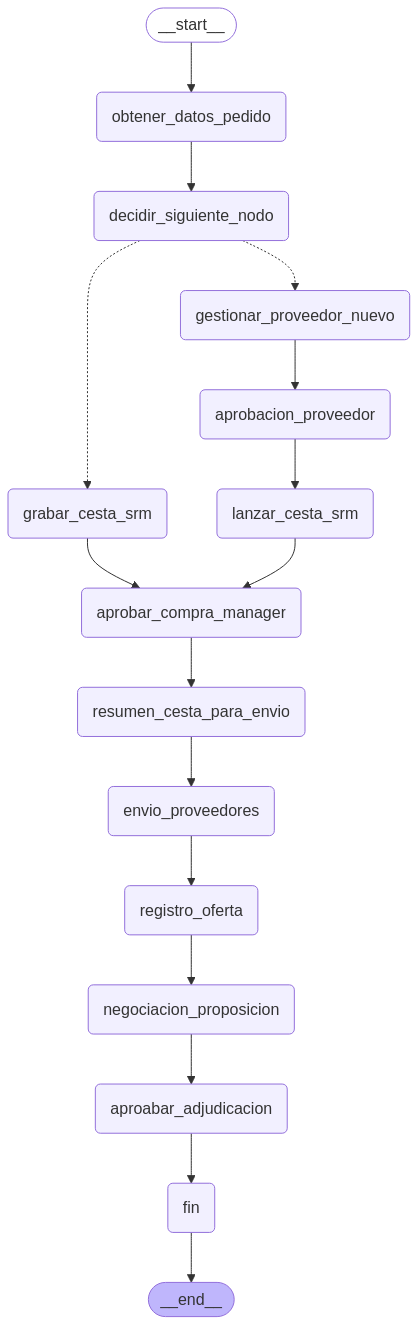

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))